In [9]:
!pip -q install transformers datasets evaluate peft accelerate scikit-learn tabulate

import torch, transformers, datasets, evaluate, peft, sklearn
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("Evaluate:", evaluate.__version__)
print("PEFT:", peft.__version__)
print("Scikit-learn:", sklearn.__version__)


USE_CPU = False
device = torch.device("cpu" if USE_CPU else ("cuda" if torch.cuda.is_available() else "cpu"))
device


Torch: 2.8.0+cu126
Transformers: 4.57.0
Datasets: 4.0.0
Evaluate: 0.4.6
PEFT: 0.17.1
Scikit-learn: 1.6.1


device(type='cuda')

In [10]:
import os, json, random, numpy as np
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tabulate import tabulate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    set_seed,
)


# Reproducibility toggles
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
set_seed(SEED)


# Task / Model settings
DATASET_NAME = ("tweet_eval", "sentiment")  # 3-class: 0=neg, 1=neutral, 2=pos
MODEL_NAME   = "distilbert-base-uncased"
MAX_LEN      = 192
EPOCHS       = 3
BATCH_SIZE   = 32
LR           = 5e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.06
LOGGING_STEPS = 50

label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

# Helpers
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

def count_trainable_parameters(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total     = sum(p.numel() for p in model.parameters())
    return trainable, total

def get_training_args(output_dir):
    return TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LR,
        weight_decay=WEIGHT_DECAY,
        warmup_ratio=WARMUP_RATIO,
        logging_steps=LOGGING_STEPS,
        report_to=[],
        save_strategy="no"
    )


In [12]:
# Load only the train/validation/test splits directly
ds = load_dataset("tweet_eval", "sentiment")

print(ds)
print({split: len(ds[split]) for split in ds})

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def preprocess(batch):
    return tokenizer(batch["text"], truncation=True, max_length=MAX_LEN)

# Tokenize each split separately to avoid memory spikes
ds_enc = {}
for split in ["train", "validation", "test"]:
    ds_enc[split] = ds[split].map(
        preprocess,
        batched=True,
        remove_columns=["text"]
    )

data_collator = DataCollatorWithPadding(tokenizer)

print("Tokenization complete.")


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
{'train': 45615, 'test': 12284, 'validation': 2000}


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

✅ Tokenization complete.


In [13]:
FULL_OUT = "outputs/distilbert_full"
os.makedirs(FULL_OUT, exist_ok=True)

model_full = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

trainable_full, total_full = count_trainable_parameters(model_full)
print(f"[FULL] Trainable params: {trainable_full:,} / {total_full:,} ({trainable_full/total_full:.2%})")

args_full = get_training_args(FULL_OUT)

trainer_full = Trainer(
    model=model_full.to(device),
    args=args_full,
    train_dataset=ds_enc["train"],
    eval_dataset=ds_enc["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Training FULL fine-tuning…")
trainer_full.train()

print("Evaluating FULL on validation/test…")
val_metrics_full  = trainer_full.evaluate(ds_enc["validation"])
test_metrics_full = trainer_full.evaluate(ds_enc["test"])

print(val_metrics_full, test_metrics_full)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[FULL] Trainable params: 66,955,779 / 66,955,779 (100.00%)


/tmp/ipython-input-2552243840.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_full = Trainer(


🚀 Training FULL fine-tuning…


Step,Training Loss
50,1.057300
100,0.956700
150,0.785800
200,0.761400
250,0.740100
300,0.742900
350,0.729800
400,0.671100
450,0.680800
500,0.668400


📏 Evaluating FULL on validation/test…


{'eval_loss': 0.8080361485481262, 'eval_accuracy': 0.7365, 'eval_precision': 0.7193741893051117, 'eval_recall': 0.7242093349688288, 'eval_f1': 0.7215116628085422, 'eval_runtime': 2.8053, 'eval_samples_per_second': 712.934, 'eval_steps_per_second': 22.457, 'epoch': 3.0} {'eval_loss': 0.9656400084495544, 'eval_accuracy': 0.6794203842396613, 'eval_precision': 0.6720026399769735, 'eval_recall': 0.6883680841196659, 'eval_f1': 0.6790668419891907, 'eval_runtime': 15.4741, 'eval_samples_per_second': 793.845, 'eval_steps_per_second': 24.816, 'epoch': 3.0}


In [14]:
from peft import LoraConfig, get_peft_model, TaskType

LORA_OUT = "outputs/distilbert_lora"
os.makedirs(LORA_OUT, exist_ok=True)

model_lora = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

lora_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_lin","k_lin","v_lin","out_lin","lin1","lin2"],
)

model_lora = get_peft_model(model_lora, lora_cfg)

trainable_lora, total_lora = count_trainable_parameters(model_lora)
print(f"[LoRA] Trainable params: {trainable_lora:,} / {total_lora:,} ({trainable_lora/total_lora:.2%})")

args_lora = get_training_args(LORA_OUT)

trainer_lora = Trainer(
    model=model_lora.to(device),
    args=args_lora,
    train_dataset=ds_enc["train"],
    eval_dataset=ds_enc["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Training LoRA…")
trainer_lora.train()

print("Evaluating LoRA on validation/test…")
val_metrics_lora  = trainer_lora.evaluate(ds_enc["validation"])
test_metrics_lora = trainer_lora.evaluate(ds_enc["test"])

print(val_metrics_lora, test_metrics_lora)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[LoRA] Trainable params: 1,256,451 / 68,212,230 (1.84%)
🚀 Training LoRA…


/tmp/ipython-input-1993017670.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(


Step,Training Loss
50,1.090400
100,1.032800
150,0.996600
200,0.953300
250,0.830900
300,0.771300
350,0.769700
400,0.708800
450,0.706500
500,0.701600


📏 Evaluating LoRA on validation/test…


{'eval_loss': 0.6458767652511597, 'eval_accuracy': 0.715, 'eval_precision': 0.6934341903818333, 'eval_recall': 0.696553505097809, 'eval_f1': 0.69471815778178, 'eval_runtime': 3.288, 'eval_samples_per_second': 608.267, 'eval_steps_per_second': 19.16, 'epoch': 3.0} {'eval_loss': 0.6907168626785278, 'eval_accuracy': 0.6818625854770433, 'eval_precision': 0.6716119300156155, 'eval_recall': 0.6894299480064788, 'eval_f1': 0.6791069512614075, 'eval_runtime': 18.1255, 'eval_samples_per_second': 677.72, 'eval_steps_per_second': 21.186, 'epoch': 3.0}


In [16]:
import json
from tabulate import tabulate
import os

# Save results dict from earlier (already exists in memory)
results = {
    "dataset": "tweet_eval/sentiment",
    "model": MODEL_NAME,
    "seed": SEED,
    "full_finetune": {
        "trainable_params": int(trainable_full),
        "total_params": int(total_full),
        "val":  {k: float(v) for k, v in val_metrics_full.items()  if isinstance(v, (int, float))},
        "test": {k: float(v) for k, v in test_metrics_full.items() if isinstance(v, (int, float))},
        "output_dir": FULL_OUT,
    },
    "lora": {
        "trainable_params": int(trainable_lora),
        "total_params": int(total_lora),
        "val":  {k: float(v) for k, v in val_metrics_lora.items()  if isinstance(v, (int, float))},
        "test": {k: float(v) for k, v in test_metrics_lora.items() if isinstance(v, (int, float))},
        "output_dir": LORA_OUT,
    },
}

# Save JSON file
os.makedirs("outputs", exist_ok=True)
with open("outputs/results.json", "w") as f:
    json.dump(results, f, indent=2)

print("results.json saved successfully!")
print(json.dumps(results, indent=2))


# Table-print helper (fixed version)
def make_table_fixed(title, full_metrics, lora_metrics):
    headers = ["Strategy", "Accuracy", "Precision", "Recall", "F1"]
    rows = [
        [
            "Full FT",
            f"{full_metrics['eval_accuracy']:.4f}",
            f"{full_metrics['eval_precision']:.4f}",
            f"{full_metrics['eval_recall']:.4f}",
            f"{full_metrics['eval_f1']:.4f}",
        ],
        [
            "LoRA",
            f"{lora_metrics['eval_accuracy']:.4f}",
            f"{lora_metrics['eval_precision']:.4f}",
            f"{lora_metrics['eval_recall']:.4f}",
            f"{lora_metrics['eval_f1']:.4f}",
        ],
    ]
    print(title)
    print(tabulate(rows, headers=headers, tablefmt="github"))
    print()


# Print comparison tables
make_table_fixed(
    "**Validation Set**",
    results["full_finetune"]["val"],
    results["lora"]["val"]
)
make_table_fixed(
    "**Test Set**",
    results["full_finetune"]["test"],
    results["lora"]["test"]
)

# Parameter comparison
print(f"Trainable params — Full: {results['full_finetune']['trainable_params']:,}")
print(f"Trainable params — LoRA: {results['lora']['trainable_params']:,}")
print("Finished! Results saved at: outputs/results.json")


✅ results.json saved successfully!
{
  "dataset": "tweet_eval/sentiment",
  "model": "distilbert-base-uncased",
  "seed": 42,
  "full_finetune": {
    "trainable_params": 66955779,
    "total_params": 66955779,
    "val": {
      "eval_loss": 0.8080361485481262,
      "eval_accuracy": 0.7365,
      "eval_precision": 0.7193741893051117,
      "eval_recall": 0.7242093349688288,
      "eval_f1": 0.7215116628085422,
      "eval_runtime": 2.8053,
      "eval_samples_per_second": 712.934,
      "eval_steps_per_second": 22.457,
      "epoch": 3.0
    },
    "test": {
      "eval_loss": 0.9656400084495544,
      "eval_accuracy": 0.6794203842396613,
      "eval_precision": 0.6720026399769735,
      "eval_recall": 0.6883680841196659,
      "eval_f1": 0.6790668419891907,
      "eval_runtime": 15.4741,
      "eval_samples_per_second": 793.845,
      "eval_steps_per_second": 24.816,
      "epoch": 3.0
    },
    "output_dir": "outputs/distilbert_full"
  },
  "lora": {
    "trainable_params": 125645

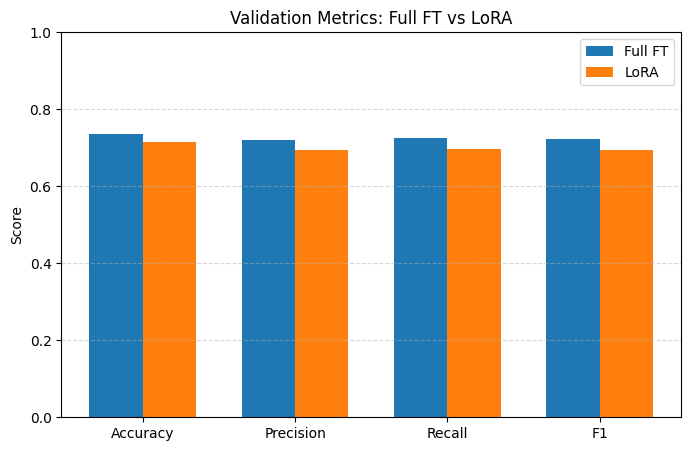

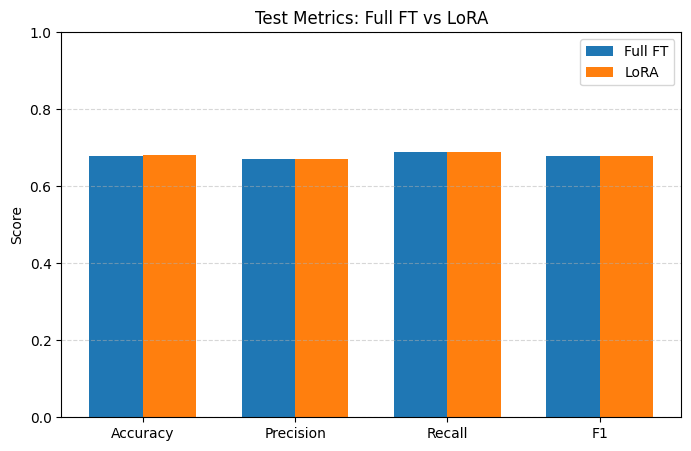

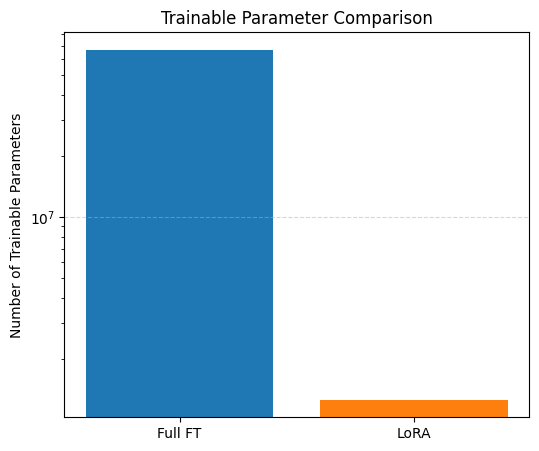

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Validation Metrics
val_full = results["full_finetune"]["val"]
val_lora = results["lora"]["val"]

metrics = ["eval_accuracy", "eval_precision", "eval_recall", "eval_f1"]
labels = ["Accuracy", "Precision", "Recall", "F1"]

full_vals_val = [val_full[m] for m in metrics]
lora_vals_val = [val_lora[m] for m in metrics]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, full_vals_val, width, label="Full FT")
plt.bar(x + width/2, lora_vals_val, width, label="LoRA")
plt.xticks(x, labels)
plt.title("Validation Metrics: Full FT vs LoRA")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


#Test Metrics
test_full = results["full_finetune"]["test"]
test_lora = results["lora"]["test"]

full_vals_test = [test_full[m] for m in metrics]
lora_vals_test = [test_lora[m] for m in metrics]

plt.figure(figsize=(8,5))
plt.bar(x - width/2, full_vals_test, width, label="Full FT")
plt.bar(x + width/2, lora_vals_test, width, label="LoRA")
plt.xticks(x, labels)
plt.title("Test Metrics: Full FT vs LoRA")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


# Trainable Parameter Comparison
trainable_full = results["full_finetune"]["trainable_params"]
trainable_lora = results["lora"]["trainable_params"]

plt.figure(figsize=(6,5))
plt.bar(["Full FT", "LoRA"], [trainable_full, trainable_lora], color=["tab:blue", "tab:orange"])
plt.title("Trainable Parameter Comparison")
plt.ylabel("Number of Trainable Parameters")
plt.yscale("log")  # Use log scale to show the gap clearly
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


In [20]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

from datasets import load_dataset

dataset = load_dataset("tweet_eval", "sentiment")
test_dataset = dataset["test"]



In [22]:
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

# Load the raw test split
from datasets import load_dataset
dataset = load_dataset("tweet_eval", "sentiment")
test_dataset = dataset["test"]

# Tokenize the test dataset
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

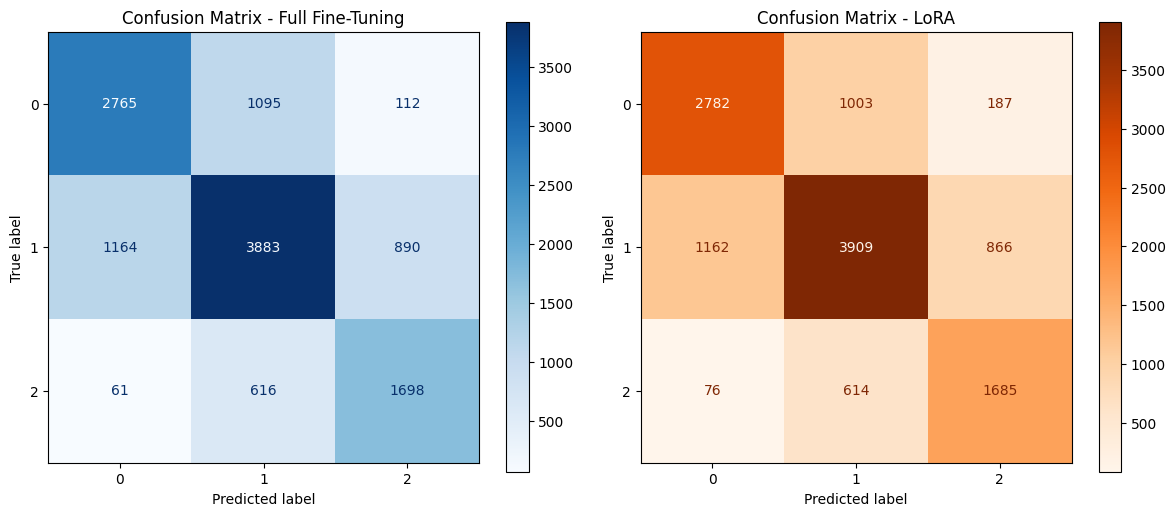

In [23]:
# Get predictions from Trainer objects
full_preds = trainer_full.predict(test_dataset)
lora_preds = trainer_lora.predict(test_dataset)

y_test = np.array(test_dataset["label"])  # true labels
full_y_pred = np.argmax(full_preds.predictions, axis=1)
lora_y_pred = np.argmax(lora_preds.predictions, axis=1)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_full = confusion_matrix(y_test, full_y_pred)
cm_lora = confusion_matrix(y_test, lora_y_pred)

disp_full = ConfusionMatrixDisplay(cm_full)
disp_lora = ConfusionMatrixDisplay(cm_lora)

disp_full.plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Confusion Matrix - Full Fine-Tuning")

disp_lora.plot(ax=axes[1], cmap='Oranges')
axes[1].set_title("Confusion Matrix - LoRA")

plt.tight_layout()
plt.show()


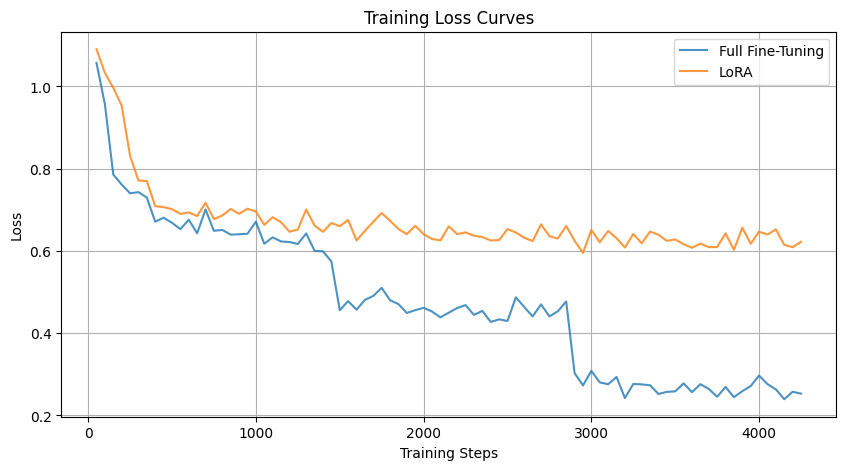

In [24]:
# Extract training losses logged during training
full_loss = trainer_full.state.log_history
lora_loss = trainer_lora.state.log_history

full_steps = [x['step'] for x in full_loss if 'loss' in x]
full_losses = [x['loss'] for x in full_loss if 'loss' in x]

lora_steps = [x['step'] for x in lora_loss if 'loss' in x]
lora_losses = [x['loss'] for x in lora_loss if 'loss' in x]

plt.figure(figsize=(10,5))
plt.plot(full_steps, full_losses, label="Full Fine-Tuning", alpha=0.8)
plt.plot(lora_steps, lora_losses, label="LoRA", alpha=0.8)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.grid(True)
plt.show()


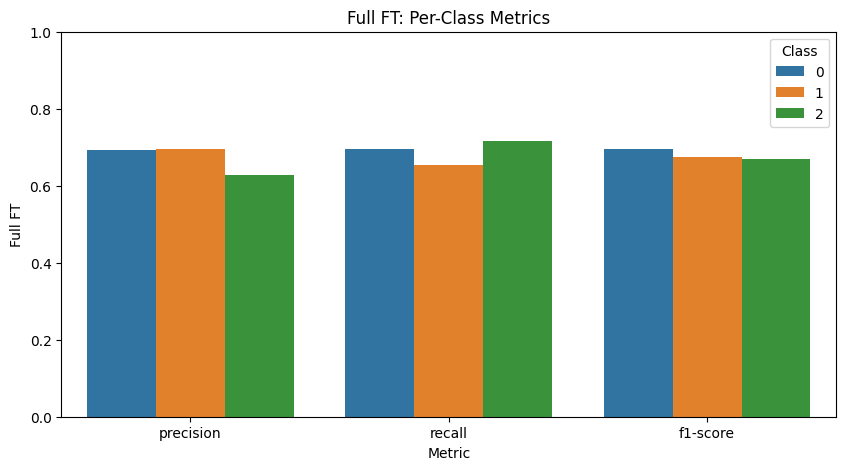

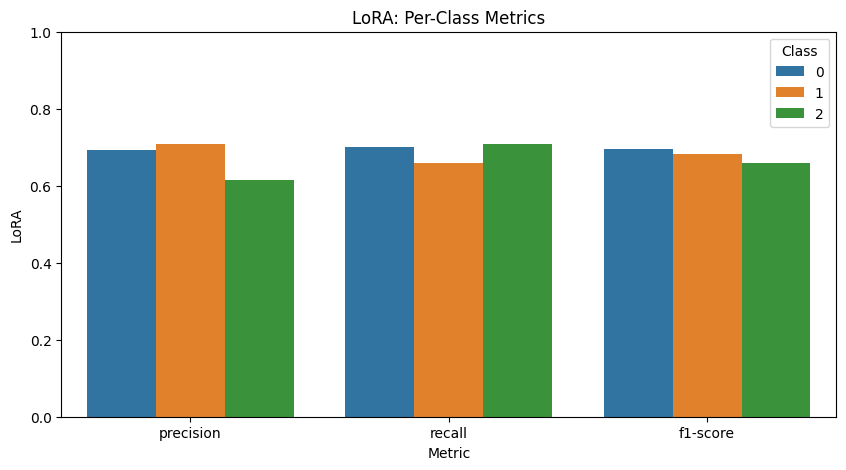

In [25]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

# Get metrics per class
report_full = classification_report(y_test, full_y_pred, output_dict=True)
report_lora = classification_report(y_test, lora_y_pred, output_dict=True)

# Take precision/recall/F1 only
metrics = ["precision", "recall", "f1-score"]
classes = ["0", "1", "2"]

data = []
for cls in classes:
    for m in metrics:
        data.append([
            cls, m,
            report_full[cls][m],
            report_lora[cls][m]
        ])

df = pd.DataFrame(data, columns=["Class", "Metric", "Full FT", "LoRA"])

plt.figure(figsize=(10,5))
sns.barplot(data=df, x="Metric", y="Full FT", hue="Class")
plt.title("Full FT: Per-Class Metrics")
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=df, x="Metric", y="LoRA", hue="Class")
plt.title("LoRA: Per-Class Metrics")
plt.ylim(0,1)
plt.show()


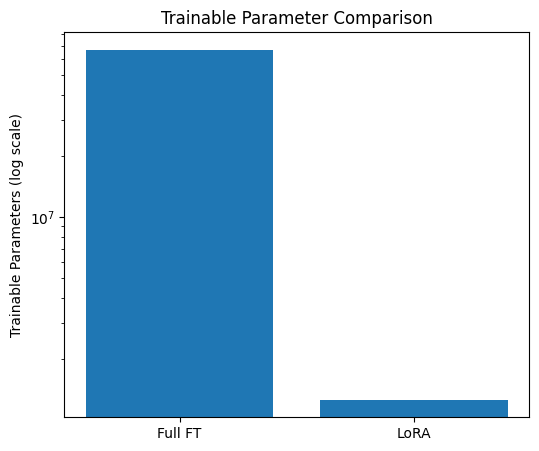

In [26]:
params_full = 66955779
params_lora = 1256451

plt.figure(figsize=(6,5))
plt.bar(["Full FT", "LoRA"], [params_full, params_lora])
plt.yscale("log")
plt.ylabel("Trainable Parameters (log scale)")
plt.title("Trainable Parameter Comparison")
plt.show()


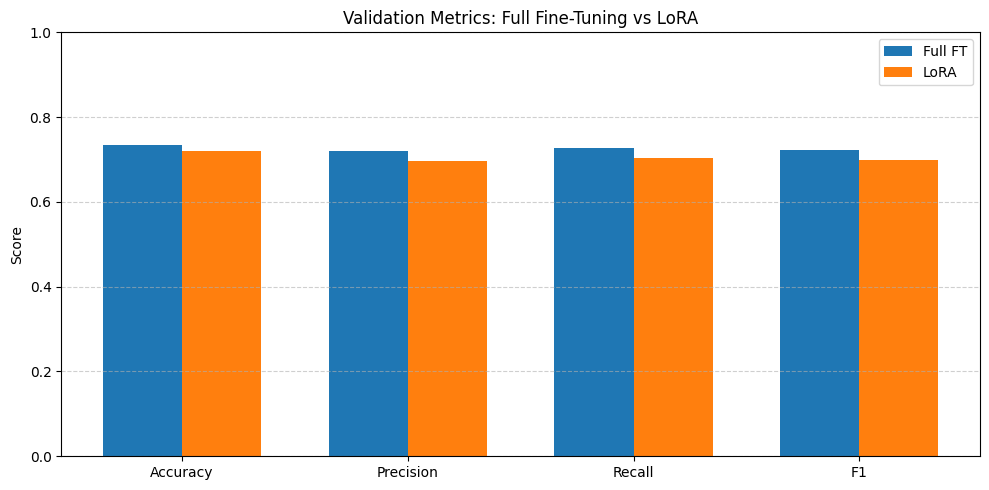

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Validation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
full_ft_scores = [0.7354, 0.7196, 0.7274, 0.7233]
lora_scores = [0.7203, 0.6967, 0.7027, 0.6993]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, full_ft_scores, width, label='Full FT')
plt.bar(x + width/2, lora_scores, width, label='LoRA')

plt.ylim(0, 1)
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Validation Metrics: Full Fine-Tuning vs LoRA')
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
